# **CoronaBERT DeepCT *Query* Expansion** 

In this notebook, I will be running experiments in order to evaluate the effectiveness of applying CoronaBERT to a DeepCT model.  Typically, the DeepCT model would be applied as a form of document expansion, but this is not feasible in the amount of time and memory available.  Instead, I will be preprocessing the queries with DeepCT, figuring out how this affects the results.  I will do this for both a DeepCT model trained with a Vanilla BERT and a DeepCT model trained with CoronaBERT.  I will then retrieve 1000 documents with BM25.  It will be tested on the CORD-19 dataset as of 16/07/2020, in accordance with the documents available for Round 5 of TREC-COVID.  The relevance judgement - qrels - used to calculate ndcg scores will be our testing dataset - the relevance judgements made for Round 5 of the challenge.  I will be evaluating the methods on the standard measures used in Round 5 of TREC-COVID.

## **Setup**

In [ ]:
%tensorflow_version 1.x
!pip install --upgrade python-terrier
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_deepct.git

TensorFlow 1.x selected.
     |████████████████████████████████| 97 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 26.3 MB/s 
     |████████████████████████████████| 69 kB 7.4 MB/s 
     |████████████████████████████████| 255 kB 45.0 MB/s 
     |████████████████████████████████| 41 kB 308 kB/s 
     |████████████████████████████████| 6.4 MB 40.4 MB/s 
     |████████████████████████████████| 1.8 MB 34.7 MB/s 
     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 294 kB 41.1 MB/s 
     |████████████████████████████████| 126 kB 42.2 MB/s 
     |████████████████████████████████| 596 kB 34.7 MB/s 
     |████████████████████████████████| 291 kB 14.3 MB/s 
     |████████████████████████████████| 59 kB 5.2 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none-any.whl size=103883 sha256=03250c8b582290bf510923489df320ed97d41d304750dc3ad9eb0b83aff98ca7
  Stored

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
assert tf.__version__.startswith("1"), "TF 1 is required by DeepCT; on Colab, use %tensorflow_version 1.x"
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
import pyterrier_deepct

In [ ]:
if not os.path.exists("marco.zip"):
  !wget http://boston.lti.cs.cmu.edu/appendices/arXiv2019-DeepCT-Zhuyun-Dai/outputs/marco.zip
  !unzip marco.zip

--2022-02-09 15:21:26--  http://boston.lti.cs.cmu.edu/appendices/arXiv2019-DeepCT-Zhuyun-Dai/outputs/marco.zip
Resolving boston.lti.cs.cmu.edu (boston.lti.cs.cmu.edu)... 128.2.207.32, 128.2.207.139
Connecting to boston.lti.cs.cmu.edu (boston.lti.cs.cmu.edu)|128.2.207.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1237248594 (1.2G) [application/zip]
Saving to: ‘marco.zip’

marco.zip           100%[===================>]   1.15G  14.1MB/s    in 2m 33s  

2022-02-09 15:23:59 (7.73 MB/s) - ‘marco.zip’ saved [1237248594/1237248594]

Archive:  marco.zip
   creating: marco/
  inflating: marco/checkpoint        
  inflating: marco/graph.pbtxt       
  inflating: marco/model.ckpt-65816.data-00000-of-00001  
  inflating: marco/model.ckpt-65816.index  
  inflating: marco/model.ckpt-65816.meta  
  inflating: marco/train.tf_record   


In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19%20Datasets/round5_index_docs.zip?raw=true
!unzip -u "/content/round5_index_docs.zip?raw=true" -d "/content/index_docs"

Archive:  drive/My Drive/Level 4 Project/Dissertation Mark 2/Datasets/Cord19 Dataset/round5_index_docs.zip
   creating: /content/index_docs/content/terrier_cord19/
  inflating: /content/index_docs/content/terrier_cord19/data.document.fsarrayfile  
  inflating: /content/index_docs/content/terrier_cord19/data.lexicon.fsomapid  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.4  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.2  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.9  
  inflating: /content/index_docs/content/terrier_cord19/data.meta.zdata  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.8  
  inflating: /content/index_docs/content/terrier_cord19/data.direct.bf  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.5  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.7  
  inflating: /content/index

In [ ]:
index = pt.IndexFactory.of("/content/index_docs/content/terrier_cord19/data.properties")

In [ ]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics('title')

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [9.52MB/s]
/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle?raw=true

with open('/content/coronaBERT_doc_embeddings.pickle?raw=true', 'rb') as f:
  doc_embeddings = pickle.load(f)

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
with open('/content/coronaBERT_query_embeddings.pickle?raw=true', 'rb') as f:
  query_embeddings = pickle.load(f)

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Models/mlpclassifier_coronaBERT.pickle?raw=true
classifier = pickle.load(open('/content/mlpclassifier_coronaBERT.pickle?raw=true', 'rb'))
classifier

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=1)

In [ ]:
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
!wget https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j4.5-5.txt

--2022-02-09 15:24:36--  https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763591 (746K) [text/plain]
Saving to: ‘qrels-covid_d4_j0.5-4.txt’

qrels-covid_d4_j0.5 100%[===================>] 745.69K   731KB/s    in 1.0s    

2022-02-09 15:24:38 (731 KB/s) - ‘qrels-covid_d4_j0.5-4.txt’ saved [763591/763591]

--2022-02-09 15:24:38--  https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34087 (33K) [text/csv]
Saving to: ‘changedIds-Jul16.csv’

changedIds-Jul16.cs 100%[===================>]  33.29K   171KB/s    in 0.2s    

2022-02-09 15:24:39 (171 KB/s) - ‘changedIds-Jul16.csv’ saved 

In [ ]:
import csv

cord_remapping = {}
with open('changedIds-Jul16.csv') as f:
  reader = csv.DictReader(f)
  for row in reader:
    cord_remapping[row['cord_uid_0619']] = row['cord_uid_0716']
len(cord_remapping)

1135

In [ ]:
from collections import Counter,defaultdict

training_judgments_by_topic = defaultdict(dict)
with open('qrels-covid_d4_j0.5-4.txt') as f:
  for line in f:
    topic_id,round_id,doc_id,relevance = line.strip('\n').split()
    topic_id = int(topic_id)
    relevance = int(relevance)
    
    if doc_id in cord_remapping:
      doc_id = cord_remapping[doc_id]

    training_judgments_by_topic[topic_id][doc_id] = relevance


In [ ]:
from collections import defaultdict
qrels = defaultdict(dict)
with open('qrels-covid_d5_j4.5-5.txt') as f:
  for line in f:
    topic_id,iteration,doc_id,judgement = line.strip('\n').split()
    topic_id = int(topic_id)
    judgement = int(judgement)
    qrels[topic_id][doc_id] = judgement

In [ ]:
test_qrels = []
for qid in qrels:
  for docno, judgement in qrels[qid].items():
    test_qrels.append([str(qid), docno, judgement])

test_qrels = pd.DataFrame(test_qrels, columns=['qid', 'docno', 'label'])

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_docs.csv?raw=true

round5_docs = pd.read_csv('/content/round5_docs.csv?raw=true').drop(columns=['Unnamed: 0'])

In [ ]:
!unzip 'drive/My Drive/Level 4 Project/Dissertation Mark 2/Datasets/CoronaBERT Model/coronabert.zip' -d 'bert-base-uncased/'
!mv 'bert-base-uncased/coronabert/README.md' 'bert-base-uncased/'
!mv 'bert-base-uncased/coronabert/config.json' 'bert-base-uncased/'
!mv 'bert-base-uncased/coronabert/special_tokens_map.json' 'bert-base-uncased/'
!mv 'bert-base-uncased/coronabert/tf_model.preproc' 'bert-base-uncased/'
!mv 'bert-base-uncased/coronabert/vocab.txt' 'bert-base-uncased/'
!mv 'bert-base-uncased/coronabert/tokenizer_config.json' 'bert-base-uncased/'
!rm -rf 'bert-base-uncased/coronabert'

Archive:  drive/My Drive/Level 4 Project/Dissertation Mark 2/Datasets/CoronaBERT Model/coronabert.zip
   creating: bert-base-uncased/coronabert/.git/
  inflating: bert-base-uncased/coronabert/.git/config  
  inflating: bert-base-uncased/coronabert/.git/description  
 extracting: bert-base-uncased/coronabert/.git/HEAD  
   creating: bert-base-uncased/coronabert/.git/hooks/
  inflating: bert-base-uncased/coronabert/.git/hooks/applypatch-msg.sample  
  inflating: bert-base-uncased/coronabert/.git/hooks/commit-msg.sample  
  inflating: bert-base-uncased/coronabert/.git/hooks/fsmonitor-watchman.sample  
  inflating: bert-base-uncased/coronabert/.git/hooks/post-checkout  
  inflating: bert-base-uncased/coronabert/.git/hooks/post-commit  
  inflating: bert-base-uncased/coronabert/.git/hooks/post-merge  
  inflating: bert-base-uncased/coronabert/.git/hooks/post-update.sample  
  inflating: bert-base-uncased/coronabert/.git/hooks/pre-applypatch.sample  
  inflating: bert-base-uncased/coronabert

In [ ]:
deepct = pyterrier_deepct.DeepCTTransformer("bert-base-uncased/config.json", "marco/model.ckpt-65816")

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


## **CoronaBERT DeepCT Retrieval**

In [ ]:
def deep_ct_query_expansion(q):
  
  
  query = q['query']

  df = pd.DataFrame([[query, '1']], columns=['text', 'docno'])

  deepct_df = deepct(df)

  deepct_query = deepct_df.iloc[0]['text']

  return deepct_query

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel='BM25')
deep_ct_expansion = pt.apply.query(deep_ct_query_expansion)
pipeline = deep_ct_expansion >> bm25

In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]['query']
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = bm25(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
100%|██████████| 50/50 [00:04<00:00, 12.11it/s]


In [ ]:
scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

bm25_results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]
  query = pd.DataFrame([[query.qid, query.query]], columns=['qid', 'query'])
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = pipeline(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

100%|██████████| 50/50 [04:42<00:00,  5.65s/it]


In [ ]:
scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

deepct_results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

In [ ]:
from pyterrier.measures import *

cornabert_results = pt.Experiment([
  bm25_results,
  deepct_results
  ],
  topics,
  test_qrels,
  names=["BM25 Baseline", "BM25 - Queries Expanded with CoronaBERT DeepCT"],
  eval_metrics=["ndcg_cut.20", P@20, Bpref, 'map'],
  baseline=0
)

In [ ]:
cornabert_results

,name,map,Bpref,P@20,ndcg_cut.20,map +,map -,map p-value,Bpref +,Bpref -,Bpref p-value,P@20 +,P@20 -,P@20 p-value,ndcg_cut.20 +,ndcg_cut.20 -,ndcg_cut.20 p-value
0,BM25 Baseline,0.160014,0.322114,0.490,0.465319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 - Queries Expanded with CoronaBERT DeepCT,0.160124,0.320815,0.476,0.453218,18.0,24.0,0.972617,16.0,26.0,0.776425,8.0,13.0,0.070245,18.0,21.0,0.116625


In [ ]:
print(cornabert_results[['name', 'map', 'Bpref', 'P@20', 'ndcg_cut.20', 'map p-value', 'Bpref p-value', 'P@20 p-value', 'ndcg_cut.20 p-value']].to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
                                          name &      map &    Bpref &  P@20 &  ndcg\_cut.20 &  map p-value &  Bpref p-value &  P@20 p-value &  ndcg\_cut.20 p-value \\
\midrule
                                 BM25 Baseline & 0.160014 & 0.322114 & 0.490 &     0.465319 &          NaN &            NaN &           NaN &                  NaN \\
BM25 - Queries Expanded with CoronaBERT DeepCT & 0.160124 & 0.320815 & 0.476 &     0.453218 &     0.972617 &       0.776425 &      0.070245 &             0.116625 \\
\bottomrule
\end{tabular}



## **Vanilla BERT DeepCT Retrieval**

In [ ]:
!rm -rf bert-base-uncased/

In [ ]:
if not os.path.exists("uncased_L-12_H-768_A-12.zip"):
  !wget https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip
  !unzip uncased_L-12_H-768_A-12.zip
  !mkdir -p bert-base-uncased
  !mv vocab.txt bert_* bert-base-uncased/

--2022-02-09 15:29:50--  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408102251 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 389.20M  77.3MB/s    in 6.2s    

2022-02-09 15:29:57 (63.2 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [408102251/408102251]

Archive:  uncased_L-12_H-768_A-12.zip
  inflating: bert_model.ckpt.data-00000-of-00001  
  inflating: bert_config.json        
  inflating: vocab.txt               
  inflating: bert_model.ckpt.index   


In [ ]:
deepct = pyterrier_deepct.DeepCTTransformer("bert-base-uncased/bert_config.json", "marco/model.ckpt-65816")

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel='BM25')
deep_ct_expansion = pt.apply.query(deep_ct_query_expansion)
pipeline = deep_ct_expansion >> bm25

In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]
  query = pd.DataFrame([[query.qid, query.query]], columns=['qid', 'query'])
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = pipeline(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

100%|██████████| 50/50 [04:43<00:00,  5.67s/it]


In [ ]:
scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

deepct_results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

In [ ]:
vbert_results = pt.Experiment([
  bm25_results,
  deepct_results
  ],
  topics,
  test_qrels,
  names=["BM25 Baseline", "BM25 - Queries Expanded with Vanilla BERT DeepCT"],
  eval_metrics=["ndcg_cut.20", P@20, Bpref, 'map'],
  baseline=0
)

# **Results**

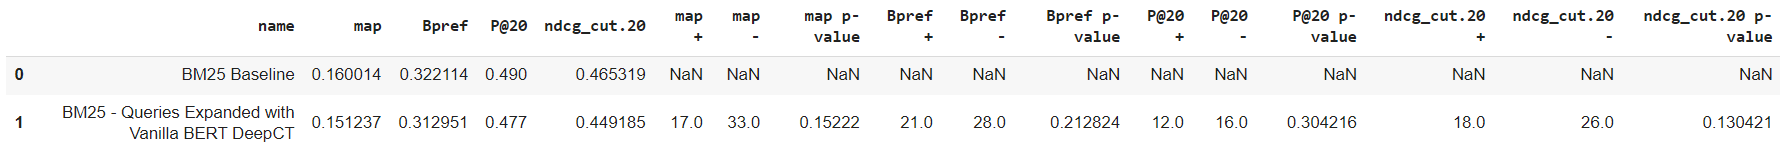

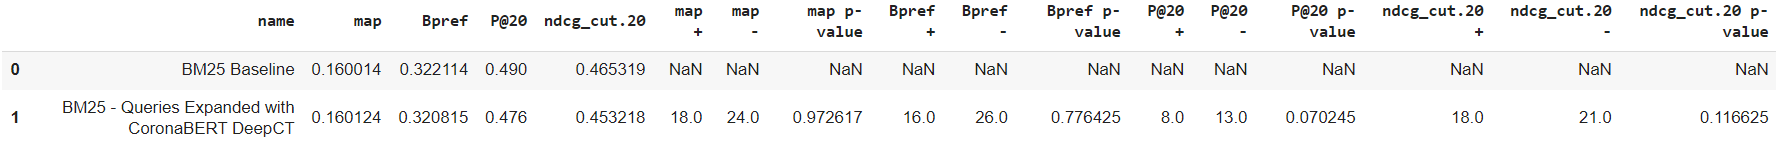